## Visualizing  Spacy + Georesolver  - Total

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of all the books of a particular edition,  and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.
                       
The query for running that we have used is the following: 

`sspark-submit --py-files defoe.zip defoe/run_queries.py nls_gaz.txt  nls -l query_distributed_topics.txt -n 16 `


And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`

### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('../../../results_Gazetteer/results_with_bb/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]    
    for i in result.keys():
        print("year %s" %i)
        t_ind = 0
        e_ind = 0
        year = i
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
            if locs != {}:
                data=[]
                l_ind = 0
                for t in locs:
                    if type(locs[t]) == type([]) :
                        c_locs=locs[t].copy()
                        c_locs.append(t.split("-")[0])
                        c_locs.append(page)
                        c_locs.append(year)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page', 'Year'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [26]:
def plot_bar_places(df_group_places, plot_type='resolved'):
    # this is for plotting purpose
    index = np.arange(len(df_group_places['Place']))
    plt.xlabel('Places')
    plt.ylabel('Frequency of Places')
    plt.xticks(index, df_group_places['Place'], rotation=80, fontsize=12)
    plt.xticks(index, place_label, rotation=80, fontsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)

    if plot_type == "resolved":
        plt.bar(index, df_group_places['count'], color='green')
        plt.title('15 Places most mentioned using the Original Geoparser across all Scottitsh Gazetteer')
    else:
        plt.bar(index, df_group_places['count'], color='green')
        plt.title('15 Places most mentioned but not resolved using Original Geoparser across all Scottitsh Gazetteer')

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from each directory listed in nls_gaz.txt, which each corresponds to a book of the "Scottish Gazzeters"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by year, and also gets some informative metadata


As a result we get a file per book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (en_core_web_lg)
    * year: Publication year 

`Example:
     
    - edition: '1828'
      georesolution_page:
       Aberdeen-rb19:
        - '57.1333333'
        - '-2.1'
       Edinburgh-rb7:
        - '55.9497284685701'
        - '-3.19333076477051'
    
      lang_model: en_core_web_lg
      page_filename: alto/97351031.34.xml
      text_unit id: Page27
      title: Descriptive account of the principal towns in Scotland to accompany Wood's town atlas`


### Reading the file and creating the first dataframe

In [7]:
results=read_query_results('georesolution_en_core_web_lg_total')

In [8]:
df_total= geresolution_dataframe(results)

year 1838
year 1803
year 1882
year 1842
year 1846
year 1825
year 1868
year 1828
year 1848
year 1883
year 1901
year 1806


In [9]:
df_total.head()

,Latitude,Longitude,Place,Page,Year
0,56.39153,-3.43951,Scotland,Page11,1838
1,55.65,-2.3333333,Birgham,Page11,1838
2,55.36667,-2.36667,the Cheviot Hills,Page11,1838
3,,,the Firth of Forth,Page11,1838
4,42.4514848,-71.0864414,England,Page11,1838


### Generic Explorations 

**Important: Number of Places that has been identified!**

In [10]:
df_total[["Place"]].count()

Place    198359
dtype: int64

**Important: Going to remove City of | Contry of | County of  in the strings of Places**

In [11]:
df_total['Place'] = df_total['Place'].str.replace(r'City of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'city of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'Country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'County of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'county of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'the ', '')
df_total['Place'] = df_total['Place'].str.replace(r'The ', '')

**Important: Number of Places that has been identified but not resolved!**

Creating a dataframe, df_not_resolved for futher exploration at the end of the notebook

In [12]:
df_not_resolved=df_total.loc[df_total['Latitude'] == '']
df_not_resolved.count()

Latitude     49755
Longitude    49755
Place        49755
Page         49755
Year         49755
dtype: int64

**Important: Number of Places that has been identified AND  resolved!**

In [13]:
df_total.loc[df_total['Latitude'] != ''].count()

Latitude     148604
Longitude    148604
Place        148604
Page         148604
Year         148604
dtype: int64

## Exploring the places resolved (with latitude and longitude)

**Important: New dataframe- df_resolved- with just the rows has been resolved!!**

In [14]:
df_resolved = df_total[df_total['Latitude'] != '']

In [15]:
df_resolved.count()

Latitude     148604
Longitude    148604
Place        148604
Page         148604
Year         148604
dtype: int64

Places names - forcing all to lower case, and later capitalize them

In [16]:
df2 = df_resolved.copy()
df2['Place']=df_resolved['Place'].apply(str.lower)

In [17]:
df_capitalized= df2.copy()
df_capitalized['Place']=df2['Place'].apply(str.capitalize)
#displaying just the first 15 rows
df_capitalized.head(15)

,Latitude,Longitude,Place,Page,Year
0,56.39153,-3.43951,Scotland,Page11,1838
1,55.65,-2.3333333,Birgham,Page11,1838
2,55.36667,-2.36667,Cheviot hills,Page11,1838
4,42.4514848,-71.0864414,England,Page11,1838
5,42.2670446,-70.8478224,Atlantic,Page11,1838
7,36.933119,-94.0946568,Berwick,Page11,1838
10,32.4290582,-82.7579156,Tweed,Page11,1838
11,40.9477778,-72.42277780000001,North sea,Page11,1838
12,56.39153,-3.43951,Scotland,Page11,1838
13,56.39153,-3.43951,Scotland,Page11,1838


In [23]:
df_max_geolocations = df_capitalized[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   


print(df_max_geolocations.count())
df_max_geolocations.head(15)



Latitude     11550
Longitude    11550
count        11550
dtype: int64


,Latitude,Longitude,count
8877,55.95,-3.3725,2833
8999,56,-4,2740
8654,55.8666667,-4.25,2632
9624,56.5,-4,2337
9488,56.39153,-3.43951,1690
10173,57.1666667,-2.6666667,1535
9319,56.25,-3.1666667,1236
9171,56.1166667,-3.95,1230
10218,57.20194,-2.19778,1201
8680,55.87194,-4.43306,1180


In [24]:
#Getting the 15 places (and their frequencies) most mentioned
filter_list=[]
place_label, place_freq = label_freq_places(df_capitalized, df_max_geolocations, filter_list)

0 2833 Edinburgh
1 2740 Scotland
2 2632 Glasgow
3 2337 Perthshire
4 1690 Scotland
5 1535 Aberdeenshire
6 1236 Fife
7 1230 Stirling
8 1201 Aberdeen
9 1180 Glasgow
10 1180 Lanarkshire
11 1177 Edinburgh
12 1164 Perth
13 1141 Inverness
14 1086 Tweed
15 1079 Forfarshire
16 970 Ayr
17 919 Inverness
18 879 Ross


In [25]:
#Visualizing the 15 places in a Bar plot
df_places = {'Place':place_label,'Place_freq':place_freq}
df_places_freq = pd.DataFrame(df_places)
df_group_places = df_places_freq.groupby(['Place'])['Place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   


df_group_places

,Place,count
12,Scotland,4430
3,Edinburgh,4010
6,Glasgow,3812
10,Perthshire,2337
7,Inverness,2060
1,Aberdeenshire,1535
4,Fife,1236
13,Stirling,1230
0,Aberdeen,1201
8,Lanarkshire,1180


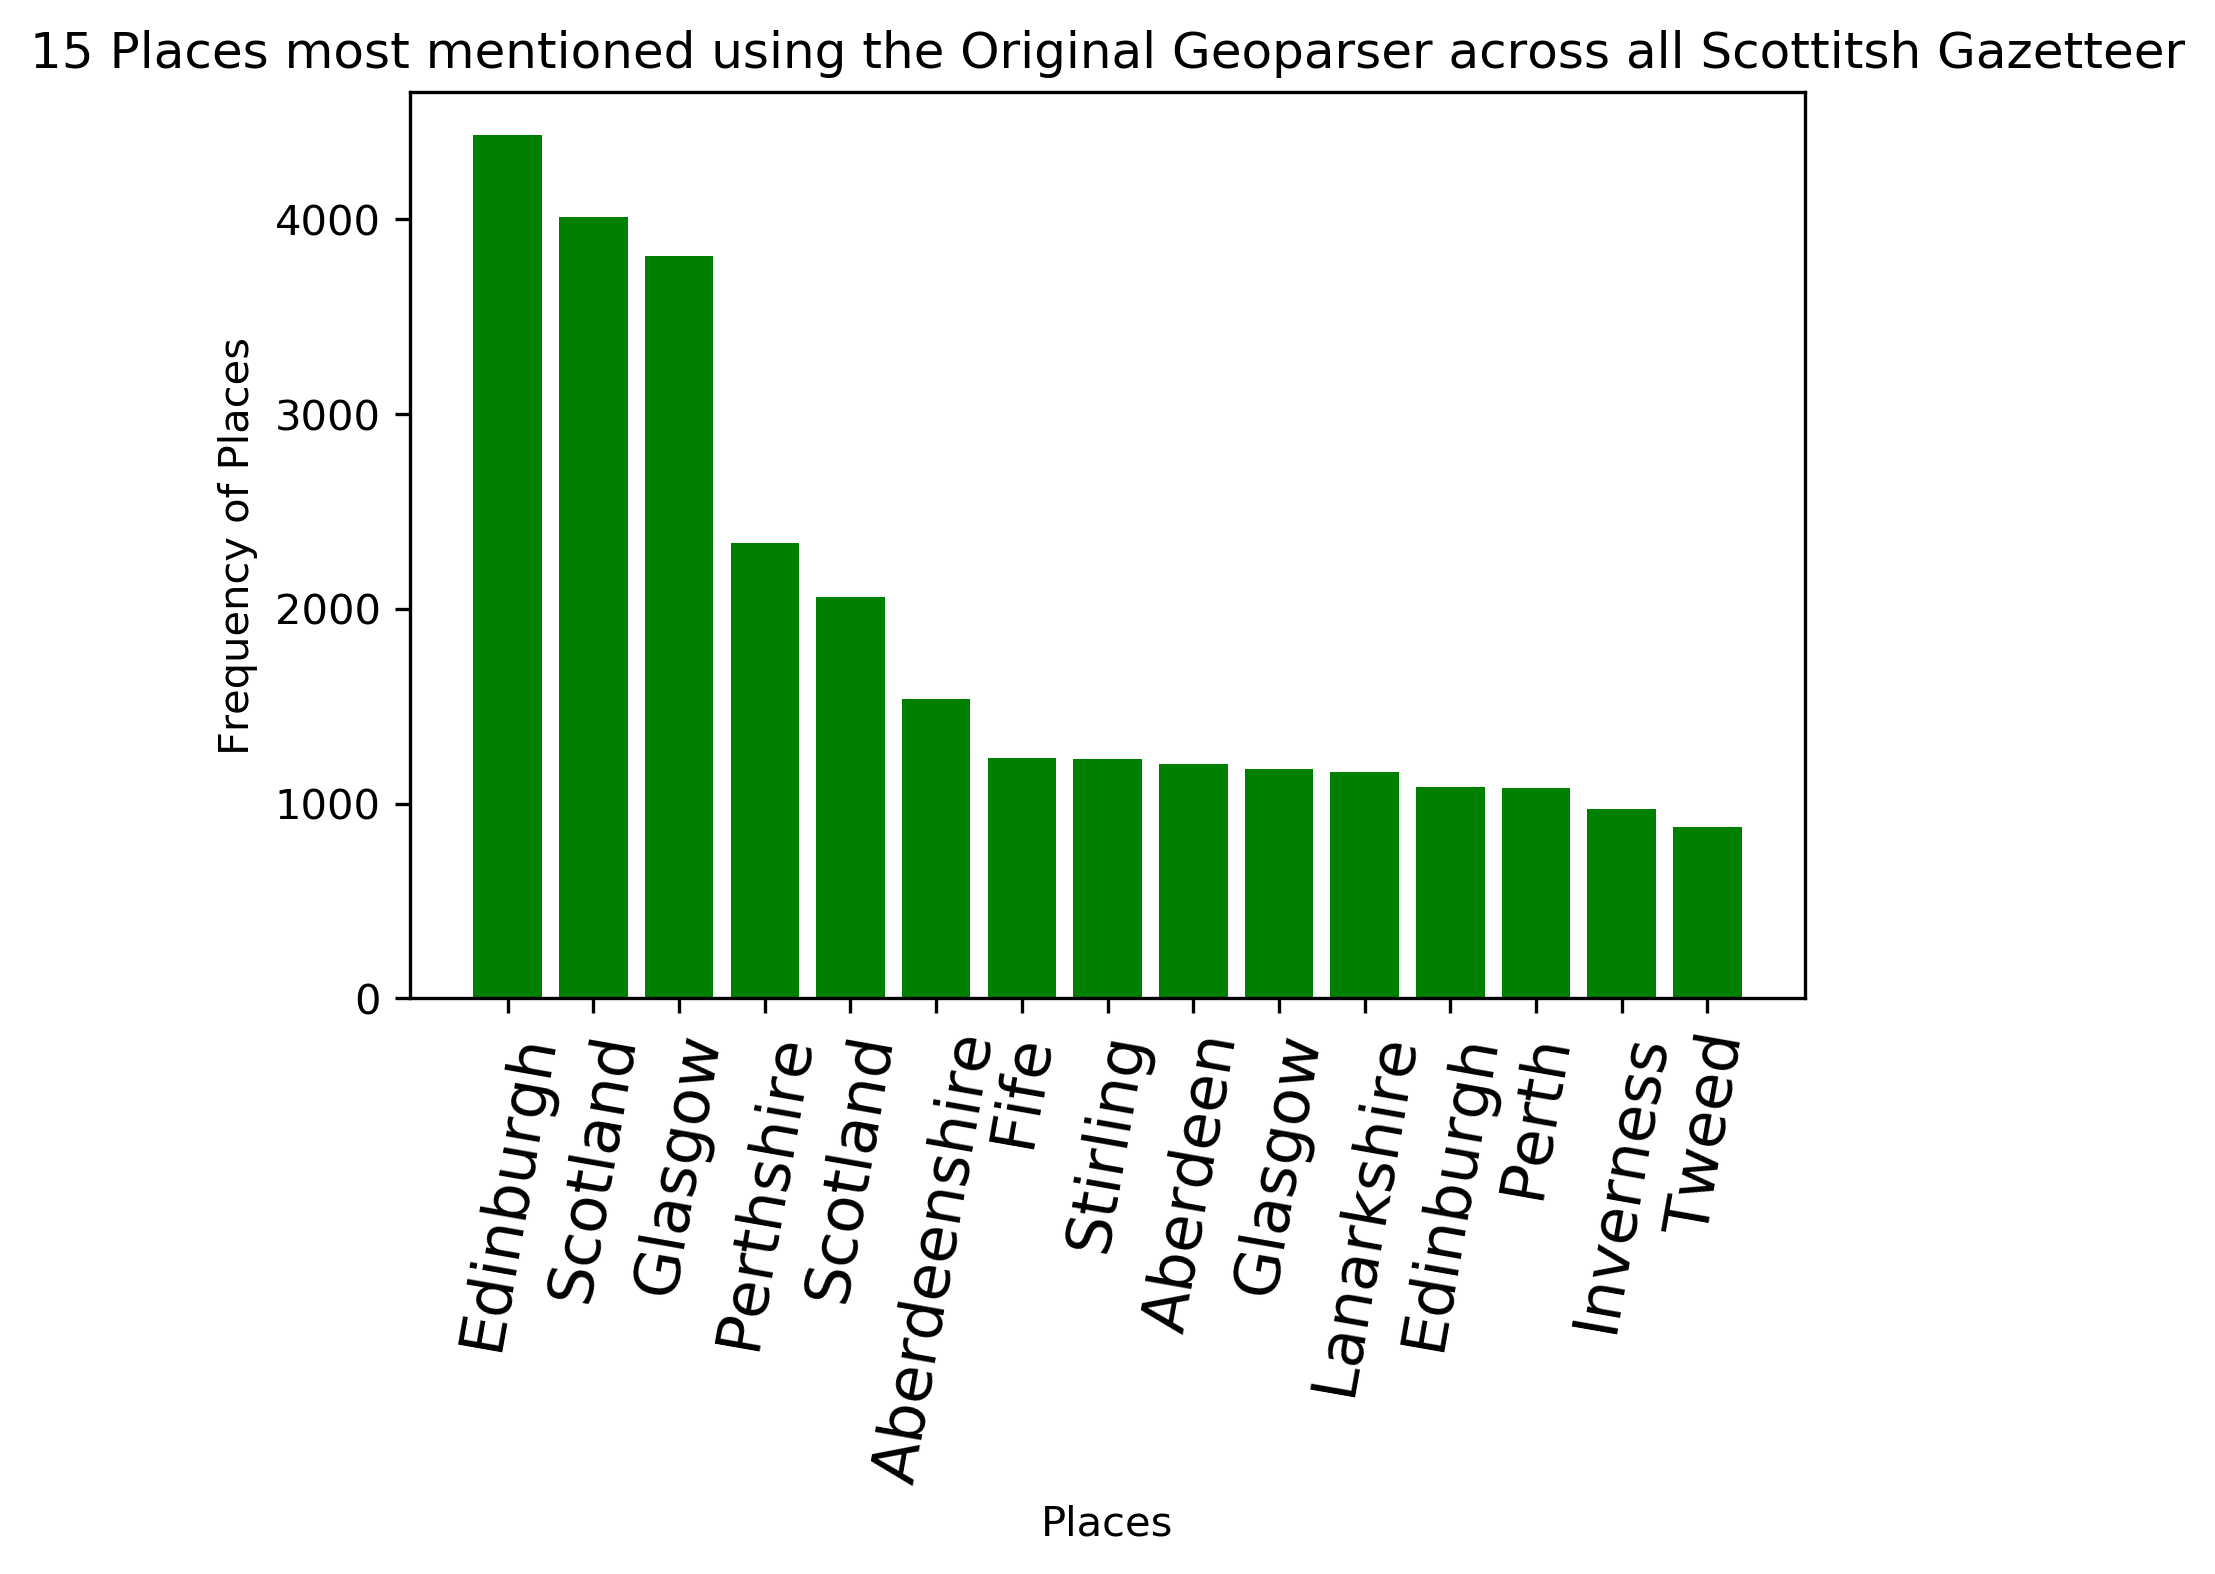

In [27]:
mpl.rcParams['figure.dpi']=300
plot_bar_places(df_group_places, plot_type='resolved')

## Exploring the locations not resolved - Not to be included in the paper

**Important - some years are missing here: 1803, 1846 (Vol 2), 1883(Vol 1, Vol 2), 1901**

Places names - forcing all to lower case, and later capitalize them

In [28]:
df4 = df_not_resolved.copy()
df4['Place']=df_not_resolved['Place'].apply(str.lower)

In [29]:
df_not_res_cap= df4.copy()
df_not_res_cap['Place']=df4['Place'].apply(str.capitalize)

In [30]:
df_not_resolved_max = df_not_res_cap[['Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   

print(df_not_resolved_max.count())
#displapying the first 15 rows
df_not_resolved_max.head(15)

Place    16272
count    16272
dtype: int64


,Place,count
14457,Sur.,1859
11171,Nw,1291
8838,Loch,822
4871,Edinburghshire,685
678,Argyleshire,668
4294,Dumfries,488
10673,Ne,419
13703,St. andrews,401
6334,Haddingtonshire,393
14485,Sw,378


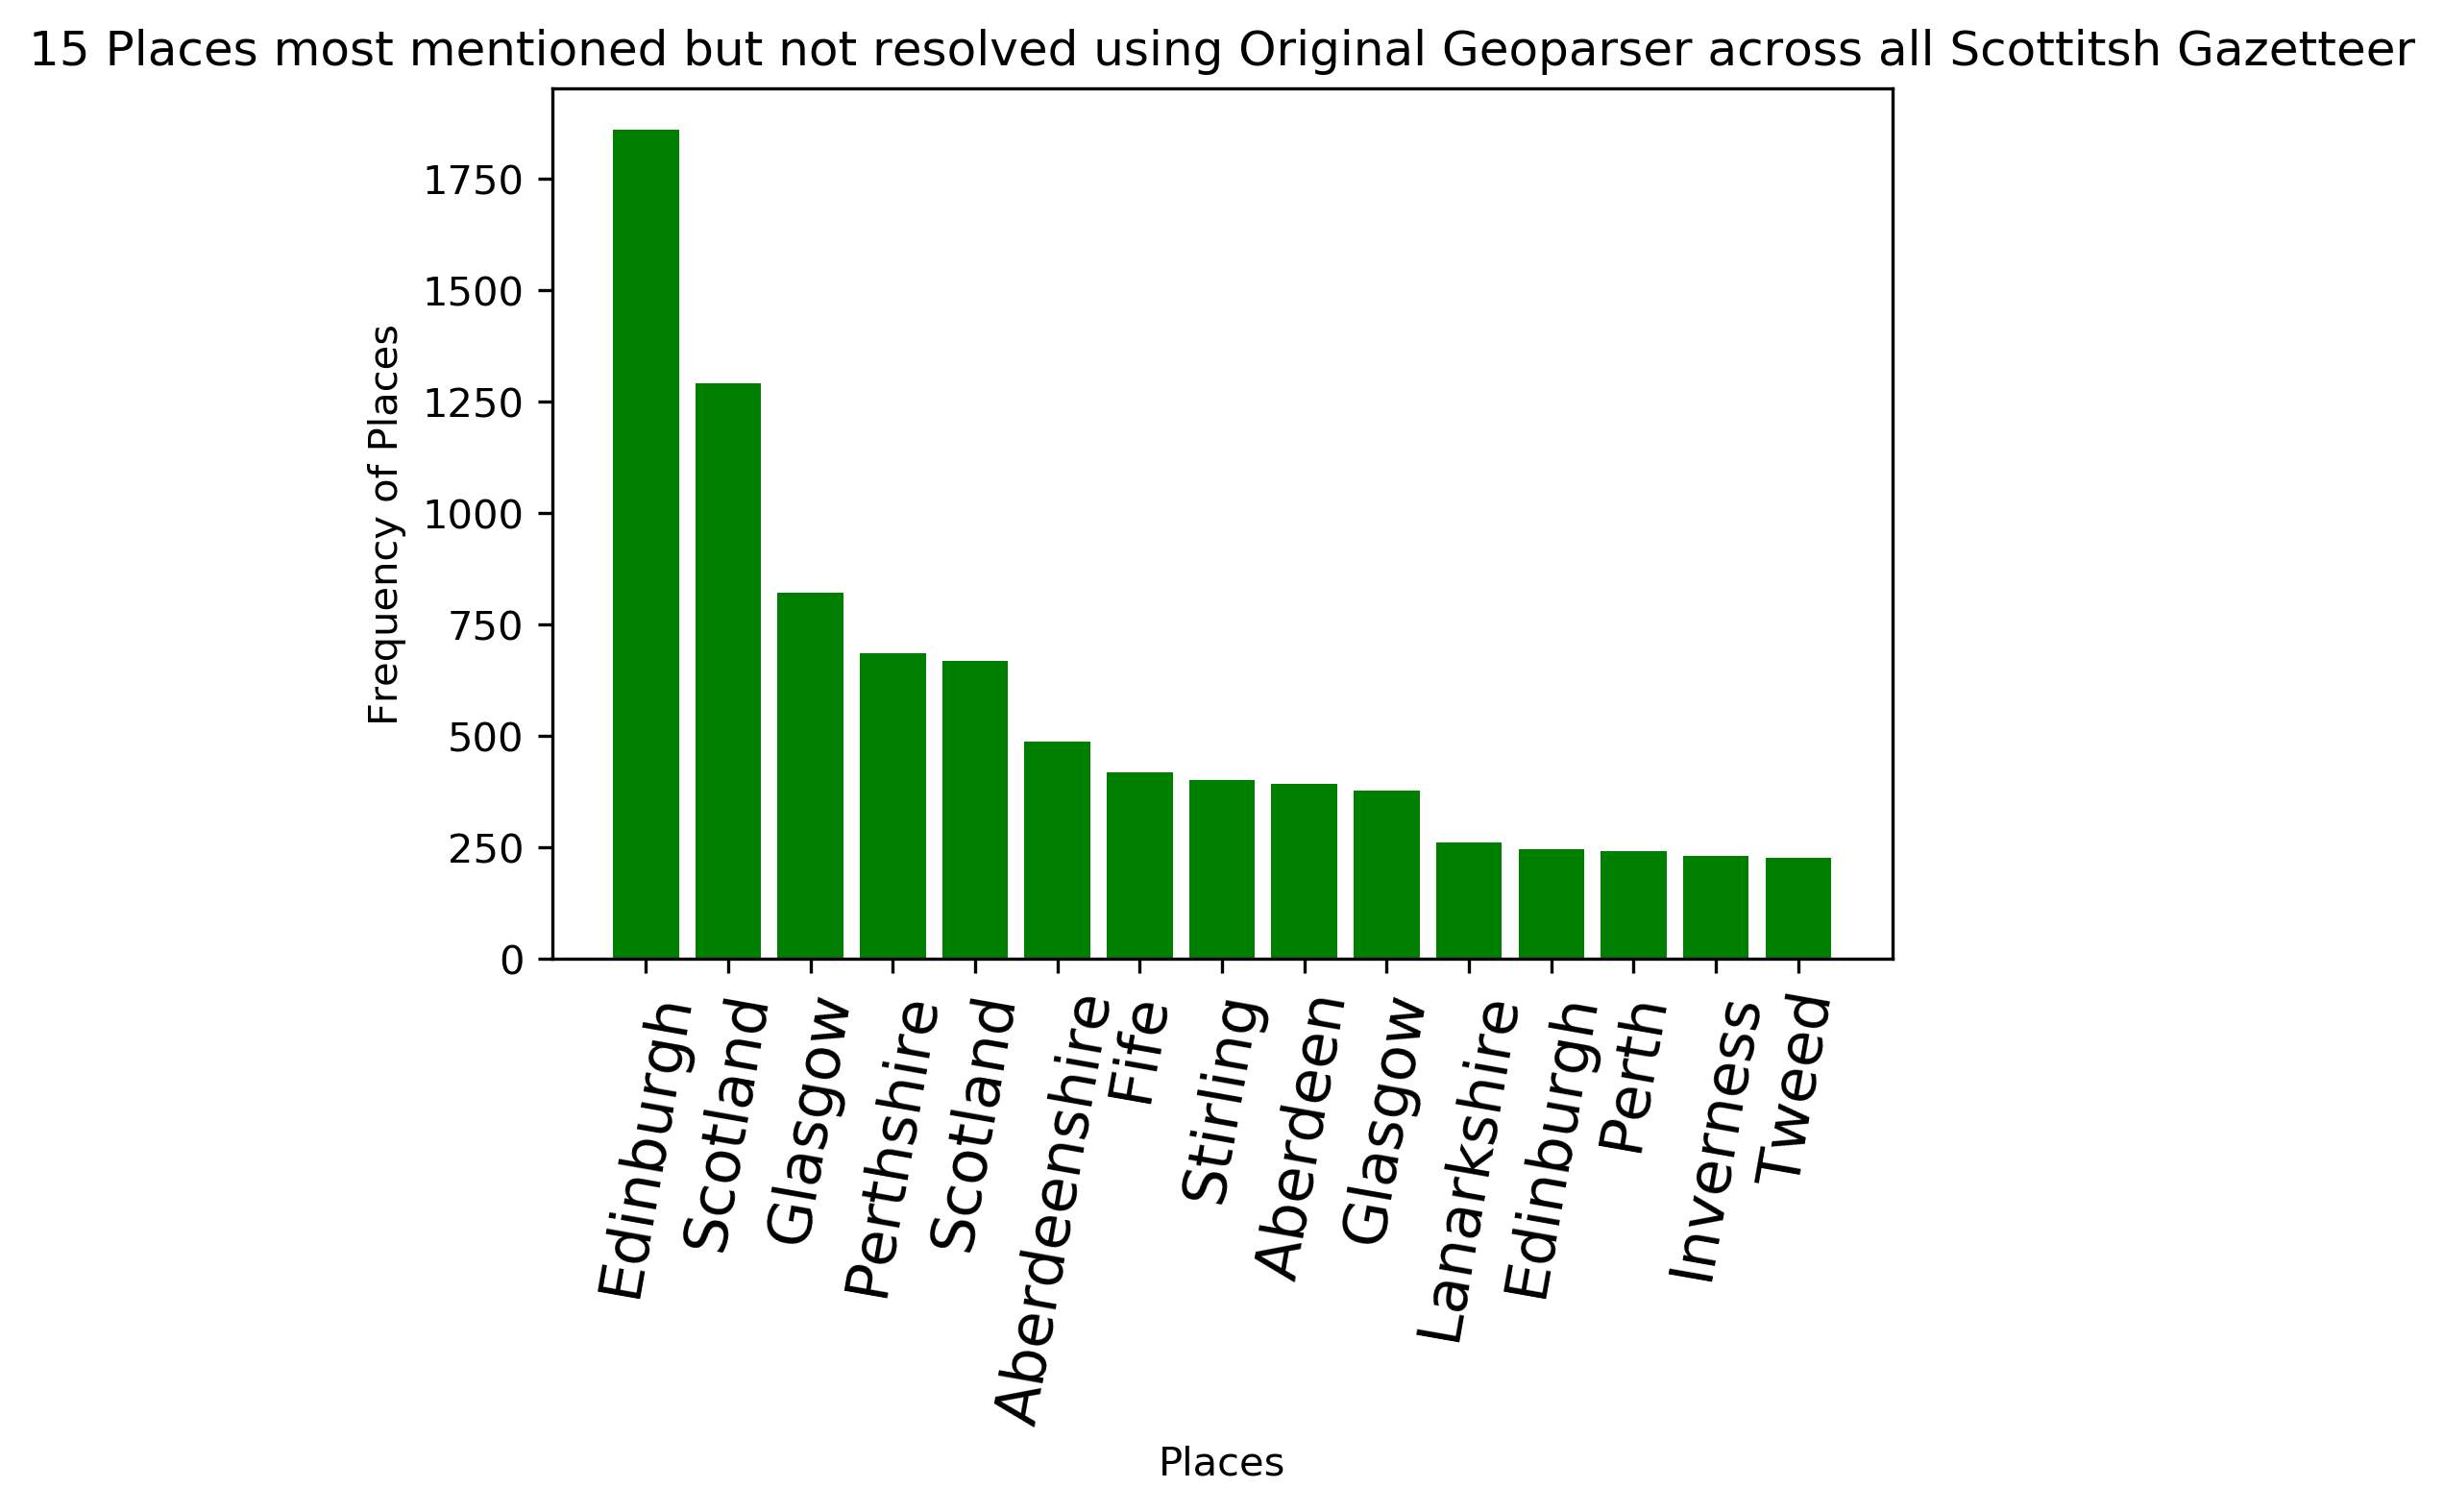

In [31]:
#Getting the 15 places (and their frequencies) most mentioned
df_not_resolved_15 = df_not_resolved_max.head(15)
plot_bar_places(df_not_resolved_15, plot_type="not_resolved")